# IMDB Review Database Prediction of Sentiment Analysis


## Step 0: Function that checks if libraries are imported for different environments

In [1]:
import importlib
import subprocess
import sys

def check_installed_and_import(import_dict):
    for module, import_as_tuple in import_dict.items():
        try:
            # Check if the module should be imported using "from x import y" syntax
            if len(import_as_tuple) == 3:
                from_module, import_module, imported_as = import_as_tuple
                imported_module = importlib.import_module(from_module)
                # Add the module to the global namespace under the 'imported_as' alias
                globals()[imported_as] = getattr(imported_module, import_module)
            else:
                import_module, imported_as = import_as_tuple
                imported_module = importlib.import_module(import_module)
                globals()[imported_as] = imported_module
                
            print(f"{module} imported as {imported_as}")
        except Exception as e:
            print(f"FAILED: {module} imported as {imported_as}. Trying to install...")
            try:
                base_module = module.split(".")[0] 
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', base_module])
                
                if len(import_as_tuple) == 3:
                    from_module, import_module, imported_as = import_as_tuple
                    imported_module = importlib.import_module(from_module)
                    globals()[imported_as] = getattr(imported_module, import_module)
                else:
                    import_module, imported_as = import_as_tuple
                    imported_module = importlib.import_module(import_module)
                    globals()[imported_as] = imported_module
                
                print(f"{module} imported as {imported_as}")
            except Exception as e:
                print(f"FAILED: {module} imported as {imported_as}. Error: {e}")


## Step 1a:  Import the necessary Libraries and downloads

In [6]:
# Call the function with our dictionary to check the modules' installation and import them
check_installed_and_import({
    'pandas': ('pandas', 'pd'),
    'zipfile': ('zipfile', 'zipfile'),
    'nltk': ('nltk', 'nltk'),
    'nltk.corpus.stopwords': ('nltk.corpus', 'stopwords', 'stopwords'),
    'nltk.stem.WordNetLemmatizer': ('nltk.stem', 'WordNetLemmatizer', 'WordNetLemmatizer'),
    'os': ('os', 'os'),
    'sklearn.model_selection.train_test_split': ('sklearn.model_selection', 'train_test_split', 'train_test_split'),
    'sklearn.feature_extraction.text.CountVectorizer': ('sklearn.feature_extraction.text', 'CountVectorizer', 'CountVectorizer'),
    'sklearn.naive_bayes.MultinomialNB': ('sklearn.naive_bayes', 'MultinomialNB', 'MultinomialNB'),
    'numpy': ('numpy', 'np'),
    'matplotlib.pyplot': ('matplotlib', 'pyplot', 'plt'),
    'seaborn': ('seaborn', 'sns'),
    'wordcloud': ('wordcloud', 'WordCloud', 'WordCloud'),
    'sklearn.metrics.confusion_matrix': ('sklearn.metrics', 'confusion_matrix', 'confusion_matrix')
    })

pandas imported as pd
zipfile imported as zipfile
nltk imported as nltk
nltk.corpus.stopwords imported as stopwords
nltk.stem.WordNetLemmatizer imported as WordNetLemmatizer
os imported as os
sklearn.model_selection.train_test_split imported as train_test_split
sklearn.feature_extraction.text.CountVectorizer imported as CountVectorizer
sklearn.naive_bayes.MultinomialNB imported as MultinomialNB
numpy imported as np
matplotlib.pyplot imported as plt
seaborn imported as sns
wordcloud imported as WordCloud
sklearn.metrics.confusion_matrix imported as confusion_matrix


## Step 2: Data Preprocessing

In [7]:
# Load the IMDB dataset from a CSV file on your local machine
# Adjust the file path as needed
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
# Since the dataset is large, we take a random sample of 5000 rows
# Adjust the number of rows as necessary to suit your machine's capabilities
data = data.sample(n=5000, random_state=42)

In [8]:
# Making nltk work
nltk.download('stopwords', download_dir='/kaggle/working/nltk_data')
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
with zipfile.ZipFile("/kaggle/working/nltk_data/corpora/wordnet.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/nltk_data/corpora/")
with zipfile.ZipFile("/kaggle/working/nltk_data/corpora/stopwords.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/nltk_data/corpora/")
nltk.data.path.append('/kaggle/working/nltk_data/corpora')

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text(0.5, 1.0, 'Original Class Distribution')

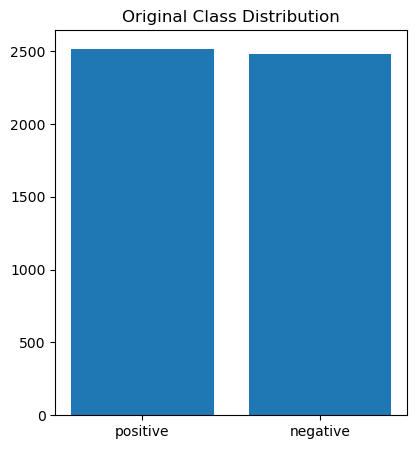

In [11]:
# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess the text
def preprocess_text(text):
    # The NLTK word_tokenize method splits the text into individual words (tokens)
    words = nltk.word_tokenize(text)

    # Next, we use a lemmatizer, which reduces words to their base or root form (e.g., 'running' becomes 'run')
    #words = [lemmatizer.lemmatize(word) for word in words]
    
    # Finally, we join the words back into a single string and return it
    text = " ".join(words)
    return text

# Apply the preprocess_text function to every review in the dataset
data['review'] = data['review'].apply(preprocess_text)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(data['sentiment'].value_counts().index, data['sentiment'].value_counts().values)
plt.title('Original Class Distribution')






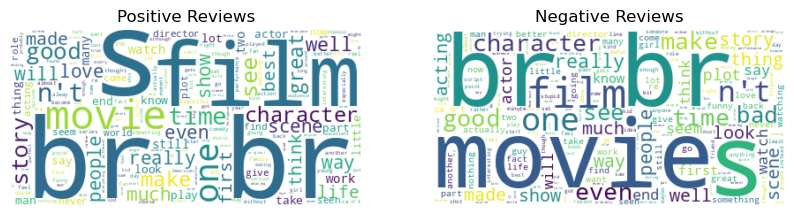

In [12]:
# Get all the positive and negative reviews
positive_reviews = data[data['sentiment'] == 'positive']['review']
negative_reviews = data[data['sentiment'] == 'negative']['review']

# Create word clouds
positive_cloud = WordCloud(background_color='white').generate(' '.join(positive_reviews))
negative_cloud = WordCloud(background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1,2,2)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')
plt.show()

## Step 3: Training the Model

In [15]:
# Split the dataset into a training set and a test set
# We use 80% of the data for training and 20% for testing
texts_train, texts_test, y_train, y_test = train_test_split(
    data['review'],
    data['sentiment'],
    test_size=0.2,
    random_state=42
    )
# The CountVectorizer converts the text reviews into a matrix of token counts
# We also use 1-grams and 2-grams (individual words and adjacent pairs of words)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# We train a Naive Bayes model using the training data
model = MultinomialNB()
model.fit(X_train, y_train)

## Step 4: Prediction

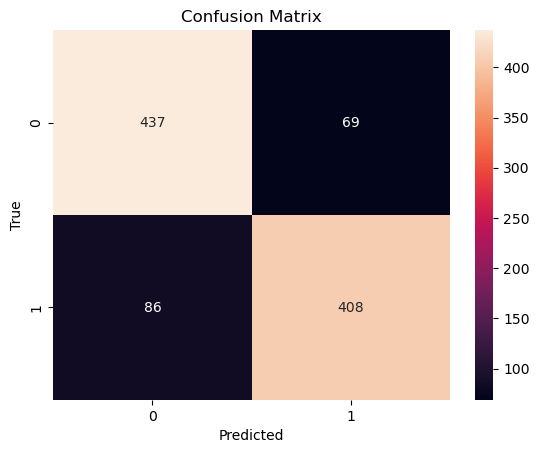

Model accuracy: 0.845


In [14]:
# Make predictions and compute the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt="d")

# Set the labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Finally, we test the model's accuracy on the test data
accuracy = model.score(X_test, y_test)
print(f'Model accuracy: {accuracy}')